In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import constants as const
import warnings
from scipy.stats import bootstrap
import scipy
from scipy import interpolate
import math
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from scipy.stats import skewnorm

dataLI = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\STPM_improved_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Exoplanet_Archive.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_like_rocky  = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
pure_rock         = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\pure-Rock (100% MgSiO3).txt",delimiter = "\t")
H20_50_300K       = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_300 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_700K       = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_700 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume



In [427]:
#list(dataLI.columns.values)

In [200]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [240]:
planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []
other_names = ['LHS 1140 c' ,'L 168-9 b', 'L 168-9 c']

for i in range(0,len(planet_name_EA)):
    if ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08 and radius_EA[i]<4:
        if "M" in str(st_spectype_EA[i]) or st_eff_EA[i] < 3500:
            if st_eff_EA[i] < 3997:
                if ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25 and math.isnan(density_unc_low_EA[i]) == False:
                    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names:
                        st_eff2.append(st_eff_EA[i])
                        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
                        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
                        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
                        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


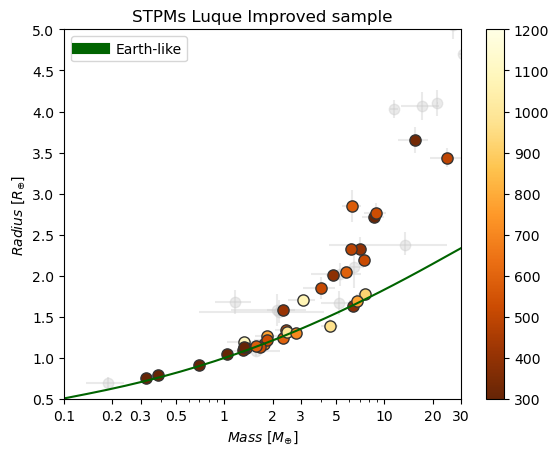

In [178]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
# plt.scatter(mass_LI[i], radius_LI[i], s=72, facecolors='none', edgecolors='0.2')

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
        densities.append(density_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("STPMs Luque Improved sample")

def find_planet(name):
    index = planet_name_LI.index(name)
    plt.plot(mass_LI[index],radius_LI[index],".", color = "blue")
    mass_err_LI_index   = [mass_unc_low_LI[index],mass_unc_up_LI[index]]
    radius_err_LI_index = [radius_unc_low_LI[index],radius_unc_up_LI[index]]
    plt.errorbar(mass_LI[index],radius_LI[index],fmt='.',markersize = 15,color = "blue",zorder=-32,alpha = 0.4)
    print(str(name) + " has a mass of " + str(mass_LI[index]) + " a radius of "+str(radius_LI[index]))


In [228]:
max(star_eff_LI[index])

3997

In [7]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()


Text(0.5, 0, '$Mass\\ [M_{\\oplus}]$')

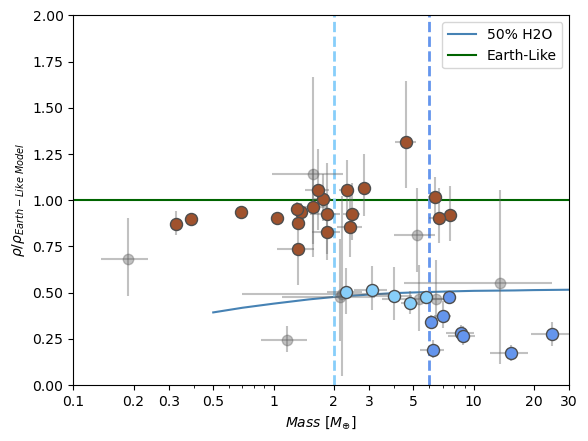

In [428]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the lines
fig, ax = plt.subplots()
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$")

(0.0, 1.5)

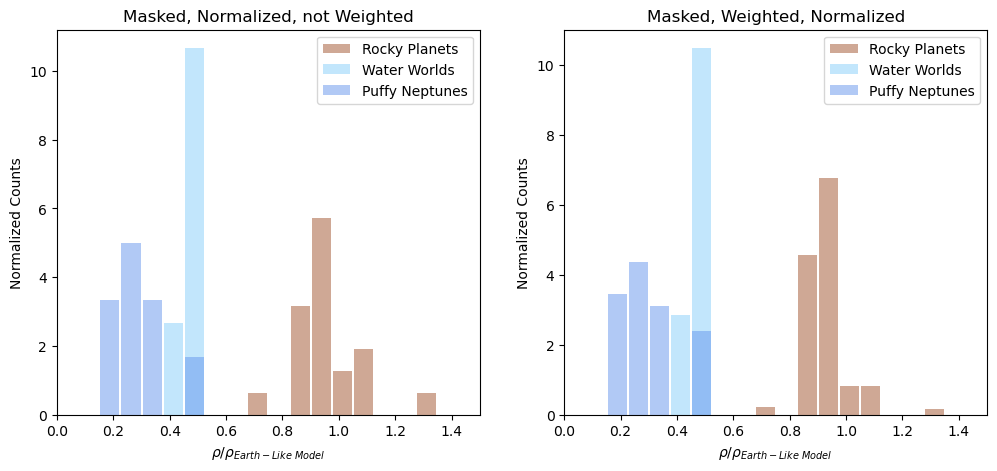

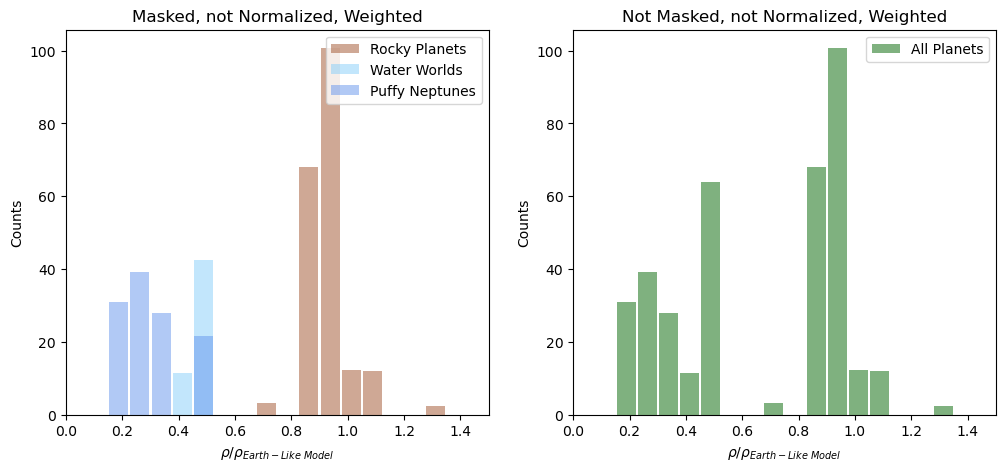

In [391]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 1.5, 21)
pbins = np.linspace(0, 1.5, 100)
###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, Normalized, not Weighted')
plt.ylabel('Normalized Counts')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)


plt.subplot(1, 2, 2)
###### Rocky Planets #####
indexs  = index_rocky
weight  = weight_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=True, weights=weight,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, Weighted, Normalized')
plt.ylabel('Normalized Counts')

leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "All Planets")
plt.title('Not Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)


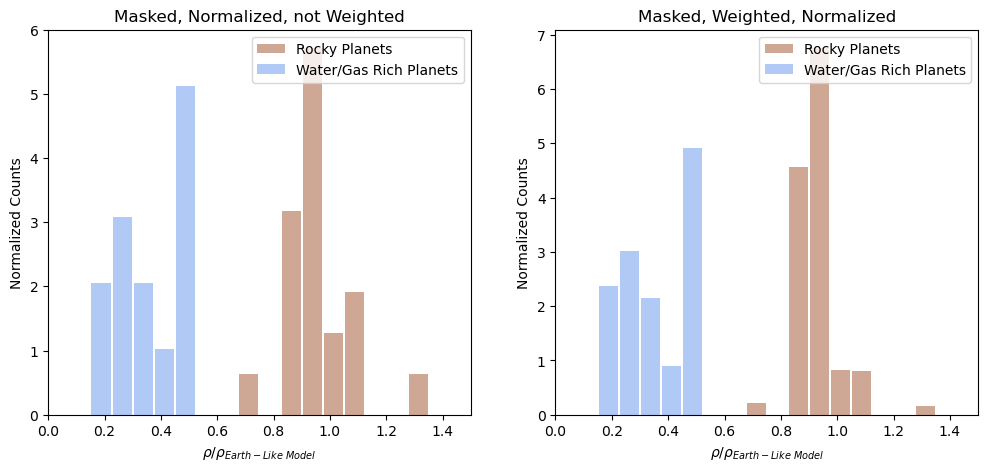

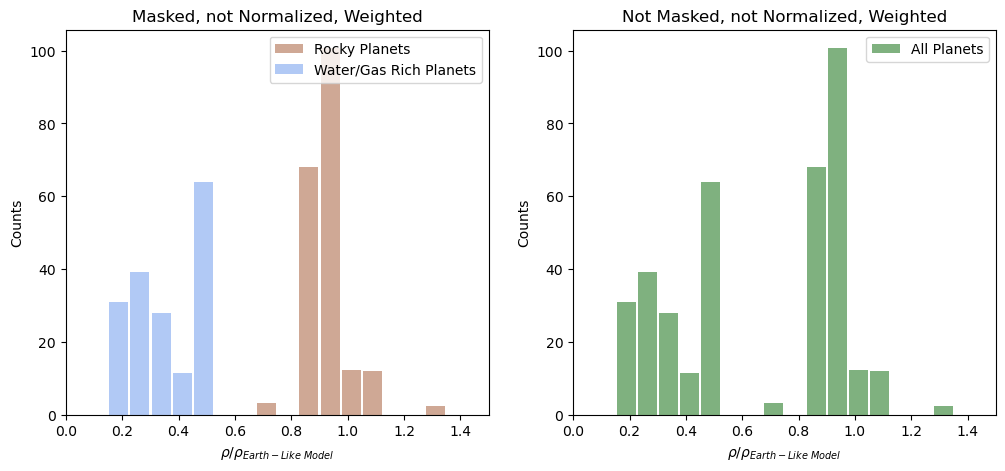

In [392]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 1.5, 21)
pbins = np.linspace(0, 1.5, 100)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Puffy Neptunes + Water Worlds ####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Water/Gas Rich Planets")

##### Plotting ######
plt.title('Masked, Normalized, not Weighted')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)
###### Rocky Planets #####
indexs  = index_rocky
weight  = weight_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight,label = "Rocky Planets")

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight,label = "Water/Gas Rich Planets")

##### Plotting ######
plt.title('Masked, Weighted, Normalized')
plt.ylabel('Normalized Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_2pop_NO_Gauss1.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Rocky Planets")

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Water/Gas Rich Planets")

##### Plotting ######
plt.title('Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight, label = "All Planets")
plt.title('Not Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_2pop_NO_Gauss2.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


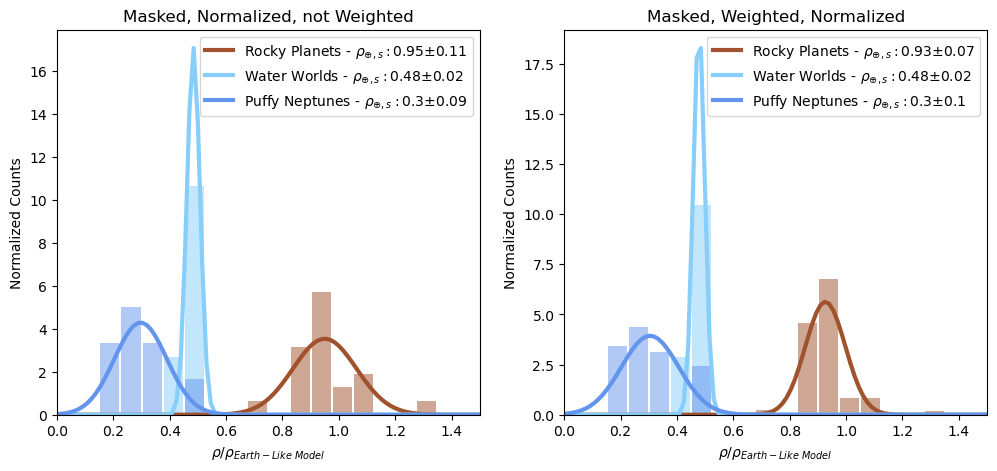

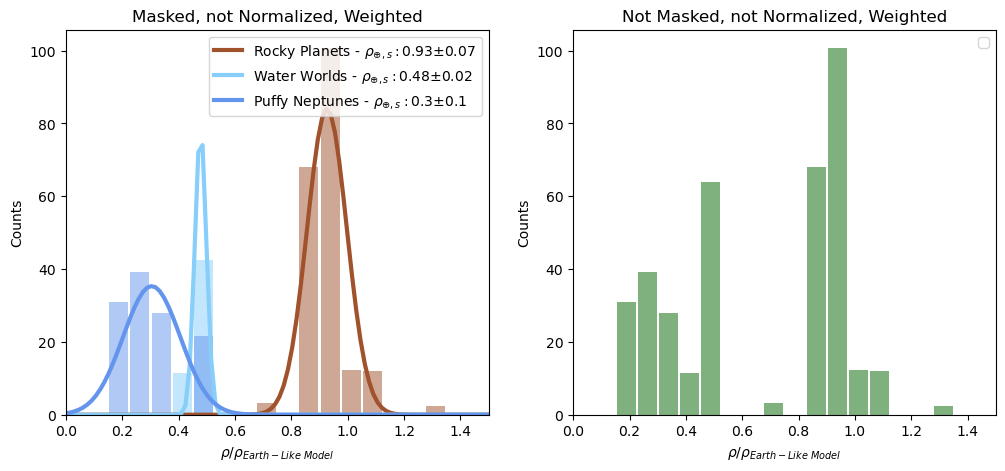

In [430]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 1.5, 21)
pbins = np.linspace(0, 1.5, 100)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs],ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Normalized, not Weighted')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)
###### Rocky Planets #####
indexs  = index_rocky
weight  = weight_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Weighted, Normalized')
plt.ylabel('Normalized Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_3pop_Gauss1.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
rocky_scale  = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
water_scale  = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
puffy_scale  = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight)
plt.title('Not Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_3pop_Gauss2.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)


In [431]:
rocky_scale

14.915541328439257

In [432]:
puffy_scale

8.974373428141927

In [433]:
water_scale

4.052930130782809

In [434]:
rocky_scale/water_scale

3.6801871355128375

In [435]:
puffy_scale/water_scale

2.2142926570531722

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


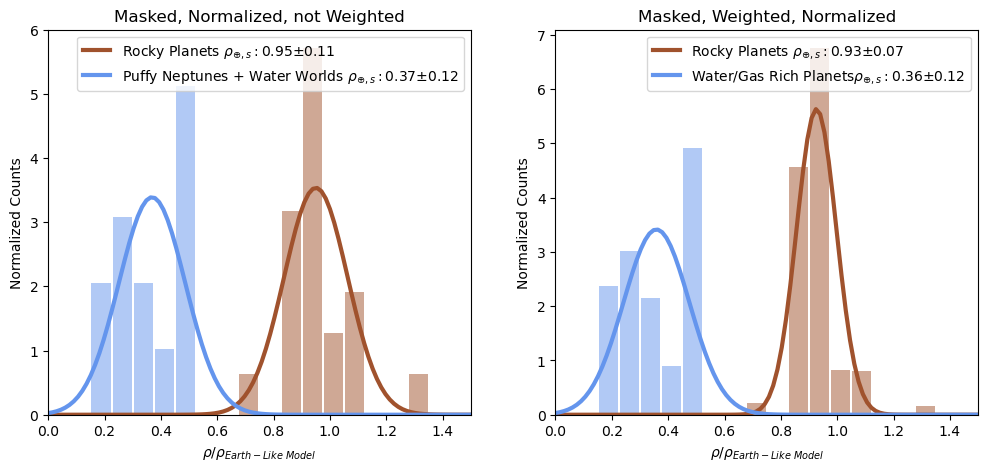

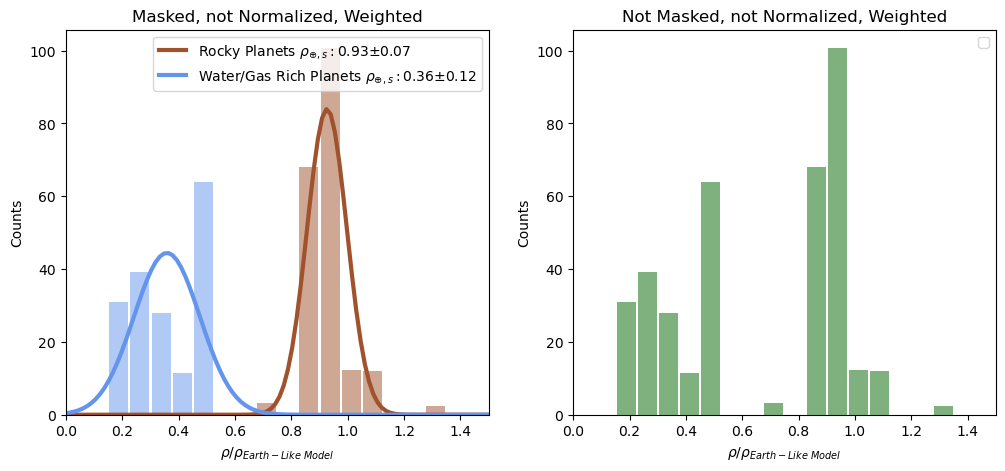

In [398]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 1.5, 21)
pbins = np.linspace(0, 1.5, 100)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Puffy Neptunes + Water Worlds ####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs],ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes + Water Worlds "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Normalized, not Weighted')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)
###### Rocky Planets #####
indexs  = index_rocky
weight  = weight_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water/Gas Rich Planets"+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Weighted, Normalized')
plt.ylabel('Normalized Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_2pop_Gauss1.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water/Gas Rich Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)


plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight)
plt.title('Not Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)
image_name = 'LIV34_Histograms_2pop_Gauss2.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


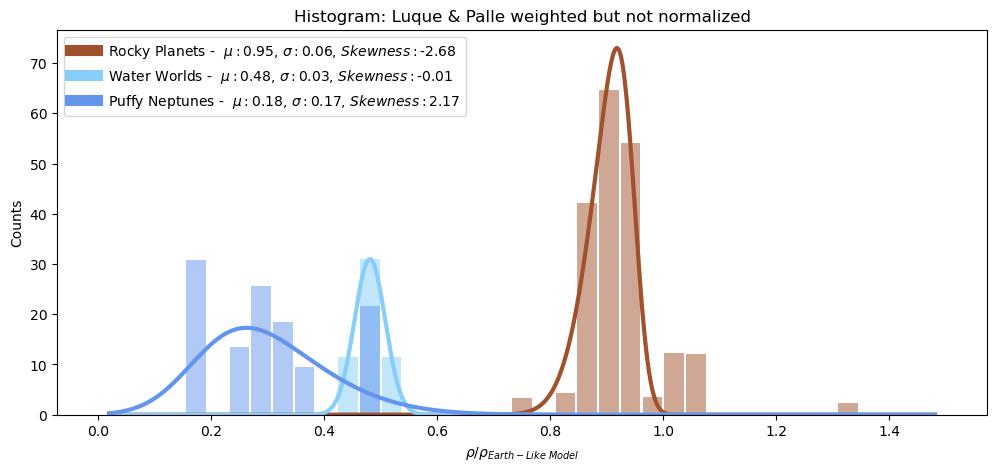

In [703]:
# Define a function for skewed Gaussian fitting
def skewed_gaussian(x, amplitude, mean, stddev, skew):
    return amplitude * skewnorm.pdf(x, skew, loc=mean, scale=stddev)

# Define a function for plotting histograms with skewed Gaussian fits
def plot_skewed_gaussian(data, weights, label, color, bins, title):
    hist, bin_edges = np.histogram(data, bins=bins, weights=weights, density=False)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    initial_params = [1.0, np.mean(data), np.std(data), 0.0]  # Adjust initial parameters
    params, _ = curve_fit(skewed_gaussian, bin_centers, hist, p0=initial_params)
    amplitude, mean, stddev, skew = params

    x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_fit = skewed_gaussian(x_fit, amplitude, mean, stddev, skew)

    plt.hist(data, bins=bins, color=color, alpha=0.5, rwidth=0.9, density=False, weights=weights)
    plt.plot(x_fit, y_fit, label=label + "  $μ:$" + f"{mean:.2f}, $σ:$" + f"{stddev:.2f}, $Skewness:$" + f"{skew:.2f}", color=color, linewidth=3)

    plt.title(title)
    plt.legend(loc='upper right')

    for line in plt.legend().get_lines():
        line.set_linewidth(8.0)

    plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
    plt.ylabel('Counts')

# Define your data and weights


fig, ax = plt.subplots(figsize=(12,5))

bins = np.linspace(0, 1.5, 40)
data_rocky = density_norm[index_rocky]
weights_rocky = weight_rocky
data_water = density_norm[index_water]
weights_water = weight_water
data_puffy = density_norm[index_puffy]
weights_puffy = weight_puffy

plot_skewed_gaussian(data_rocky, weights_rocky, "Rocky Planets -", "sienna", bins, "")
plot_skewed_gaussian(data_water, weights_water, "Water Worlds -", "lightskyblue", bins, '')
plot_skewed_gaussian(data_puffy, weights_puffy, "Puffy Neptunes -", "cornflowerblue", bins, 'Histogram: Luque & Palle weighted but not normalized')
image_name = 'LIV34_Histograms_3pop_skew.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

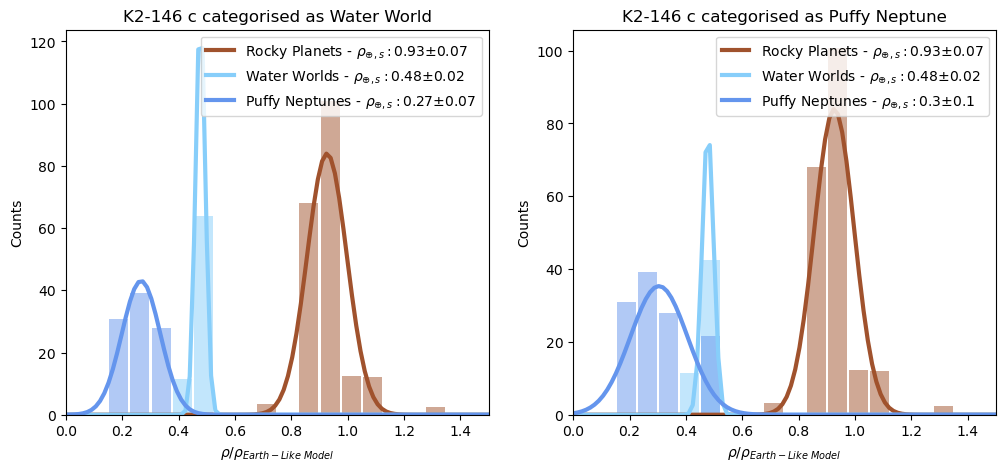

In [404]:
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 

index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)
weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('K2-146 c categorised as Water World')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 

index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('K2-146 c categorised as Puffy Neptune')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_K2-146_importance.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

## Recreating Luque & Palle histogram

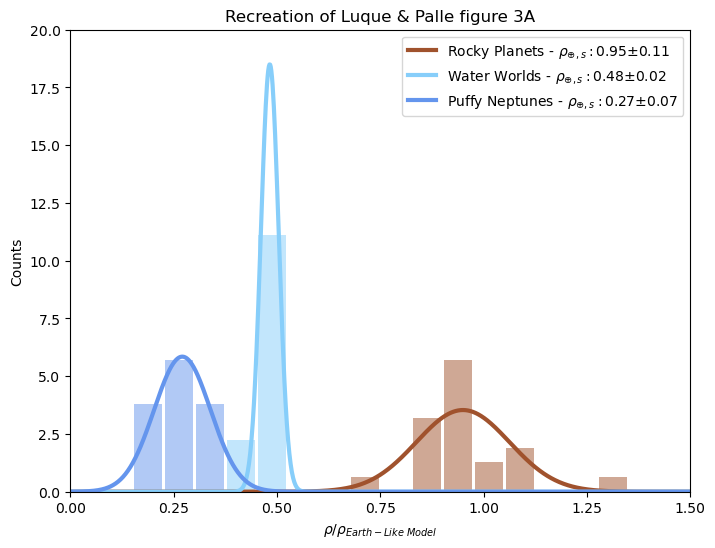

In [482]:
fig, ax = plt.subplots(figsize=(8,6))
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 

index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)
weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

bins  = np.linspace(0, 1.5, num= 21)
pbins = np.linspace(0, 1.5, 1000)
###### Rocky Planets #####
indexs = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
scale_rocky = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
scale_water = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
scale_puffy = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Recreation of Luque & Palle figure 3A')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.ylim(0,20)
plt.xticks([0,0.25,0.5,0.75,1,1.25,1.50],["0.00","0.25","0.50","0.75","1.00","1.25","1.50"],minor=False)

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
image_name = 'luque_scale_factor.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

In [476]:
scale_puffy

0.5526315789473685

In [477]:
scale_water

0.4736842105263156

In [478]:
scale_rocky

1.6578947368421053

In [481]:
scale_puffy/scale_water

1.1666666666666672

## Adding planets to the sample

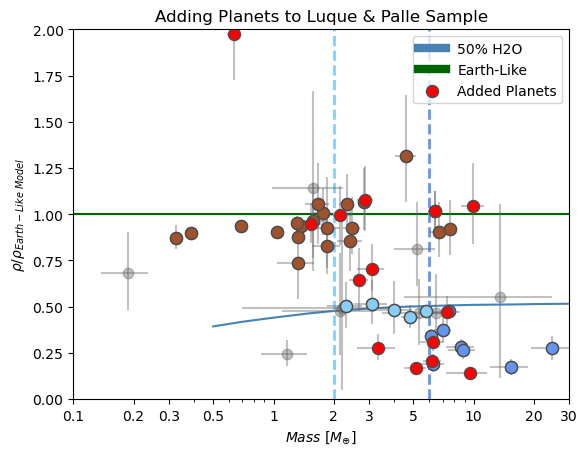

In [407]:
fig, ax = plt.subplots()
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.legend()

plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=20, edgecolor = "0.3")
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
#plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=75, edgecolor = "0.3",label = "Added Planets")

xerr = [np.abs(mass_low2), mass_up2]
yerr = [np.abs(density_low2) / np.array(rocky_density(mass2)) , density_up2 / np.array(rocky_density(mass2)) ]
plt.errorbar(mass2, np.array(density2)/ np.array(rocky_density(mass2)), xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

image_name = 'LIV34_add_DM1.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

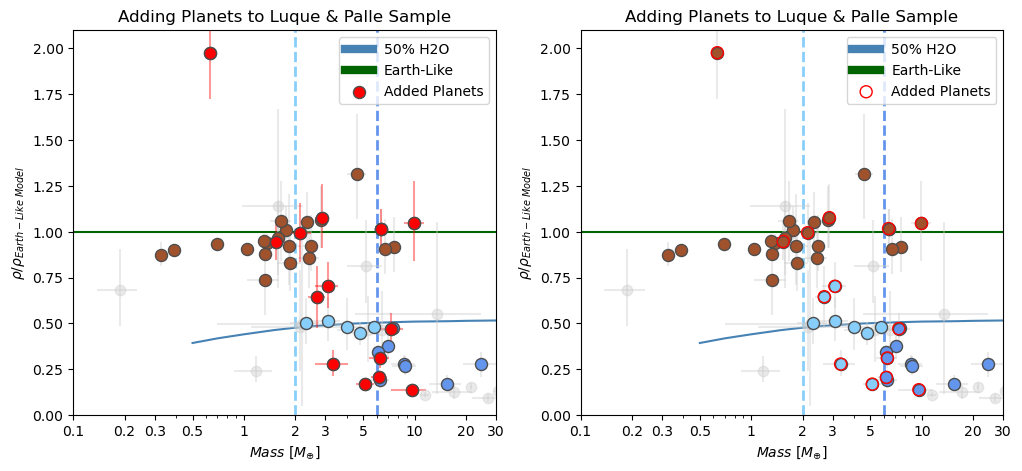

In [425]:
fig, ax = plt.subplots(figsize=(12,5))
masses_add  = np.concatenate([mass_LI[index],mass2])
radii_add   = np.concatenate([radius_LI[index],radius2])
density_add = np.concatenate([density_norm[index],np.array(density2) / np.array(rocky_density(mass2))])
selected_planets = [planet_name_LI[i] for i in index if i < len(planet_name)]
planet_name = np.concatenate([selected_planets,planet2])
xerr = [np.concatenate([mass_err_LI[0][index],np.abs(mass_low2)]), np.concatenate([mass_err_LI[1][index],np.abs(mass_up2)])]
yerr = [np.concatenate([density_err_LI[0][index],np.abs(density_low2/ np.array(rocky_density(mass2)))]) , np.concatenate([density_err_LI[1][index], np.abs(density_up2/ np.array(rocky_density(mass2))) ])]
no_plot = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] not in planets:
        no_plot.append(planet_name_LI[i])
        
index_puffy = []; index_water = []; index_rocky = []    
for i in range(0, len(planet_name)):
    if radii_add[i] < 4 and planet_name[i] not in no_plot:
        if planet_name[i] in planets or planet_name[i] in planet2:
            if abs(1- density_add[i]) < abs(density_add[i] - h20model_density(masses_add[i])):
                index_rocky.append(i)
            if masses_add[i] >= 6 and abs(1- density_add[i]) > abs(density_add[i] - h20model_density(masses_add[i])):
                index_puffy.append(i)
            if 2 <= masses_add[i] <= 6 and abs(1- density_add[i]) > abs(density_add[i] - h20model_density(masses_add[i])):
                index_water.append(i)

weight = 1/(yerr[0]**2 +yerr[1]**2 )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.errorbar(mass_LI,density_LI/ np.array(rocky_density(mass_LI)),xerr = mass_err_LI, yerr=density_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,density2/ np.array(rocky_density(mass2)),xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(density_low2/ np.array(rocky_density(mass2))),np.abs(density_up2/ np.array(rocky_density(mass2)))],fmt='.',markersize = 15,color = "red",zorder=-32,alpha = 0.4)
plt.scatter(masses_add[index_rocky], density_add[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(masses_add[index_puffy], density_add[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(masses_add[index_water], density_add[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=75, edgecolor = "0.3",label = "Added Planets")

plt.xlim(0.1, 30)
plt.ylim(0, 2.1); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.errorbar(mass_LI,density_LI/ np.array(rocky_density(mass_LI)),xerr = mass_err_LI, yerr=density_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,density2/ np.array(rocky_density(mass2)),xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(density_low2/ np.array(rocky_density(mass2))),np.abs(density_up2/ np.array(rocky_density(mass2)))],fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.scatter(masses_add[index_rocky], density_add[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(masses_add[index_puffy], density_add[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(masses_add[index_water], density_add[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),facecolor = "None",s=75, edgecolor = "red",label = "Added Planets")

plt.xlim(0.1, 30)
plt.ylim(0, 2.1); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
    
image_name = 'LIV34_add_DM.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

In [419]:
np.concatenate([mass_err_LI[0][index],np.abs(mass_low2)])

array([0.44 , 0.16 , 0.2  , 0.72 , 0.58 , 0.6  , 0.3  , 0.34 , 0.45 ,
       0.18 , 0.24 , 0.31 , 0.69 , 0.23 , 0.24 , 0.67 , 0.93 , 1.04 ,
       1.35 , 0.9  , 1.8  , 0.12 , 9.   , 1.5  , 0.86 , 0.05 , 1.2  ,
       0.3  , 0.28 , 0.069, 0.056, 0.012, 0.022, 0.031, 0.038, 0.02 ,
       0.56 , 0.26 , 0.38 , 0.46 , 5.2  , 1.4  , 3.3  , 2.31 , 0.72 ,
       0.05 , 0.34 , 0.48 , 0.61 , 0.65 , 0.44 , 0.25 , 0.19 , 1.3  ,
       0.88 , 1.24 , 0.3  ])

In [500]:
planet2

['AU Mic c',
 'GJ 3090 b',
 'GJ 367 b',
 'HD 260655 b',
 'HD 260655 c',
 'Kepler-26 b',
 'Kepler-26 c',
 'LHS 1140 b',
 'LTT 1445 A b',
 'LTT 1445 A c',
 'TOI-1075 b',
 'TOI-1201 b',
 'TOI-1470 b',
 'TOI-244 b']

In [505]:
i = 10
print(planet2[i])
print(str(mass2[i]) + "+" +str(mass_up2[i]) +str(mass_low2[i]))
print(str(radius2[i]) + "+" +str(radius_up2[i]) +str(radius_low2[i]))
print(str(density2[i]) + "+" +str(density_up2[i]) +str(density_low2[i]))
print(planet_eq2[i])
print(st_eff2[i])
print(disc_year2[i])

TOI-1075 b
9.95+1.36-1.3
1.791+0.116-0.081
9.32+2.05-1.85
1323.0
3875.0
2022


In [484]:
Name, mass, radius, density, eq. temp, st. eff. temp, year

14

In [ ]:
\multicolumn{1}{|l|}{TOI-1075 b
} &
  \multicolumn{1}{l|}{9.95+1.36-1.3
} &
  \multicolumn{1}{l|}{1.791+0.116-0.081
} &
  \multicolumn{1}{l|}{9.32+2.05-1.85
} &
  \multicolumn{1}{l|}{1323} &
  \multicolumn{1}{l|}{3875} &
  2022 \\ \hline

In [ ]:
\multicolumn{1}{|l|}{} &
  \multicolumn{1}{l|}{} &
  \multicolumn{1}{l|}{} &
  \multicolumn{1}{l|}{} &
  \multicolumn{1}{l|}{} &
  \multicolumn{1}{l|}{} &
  2022 \\ \hline

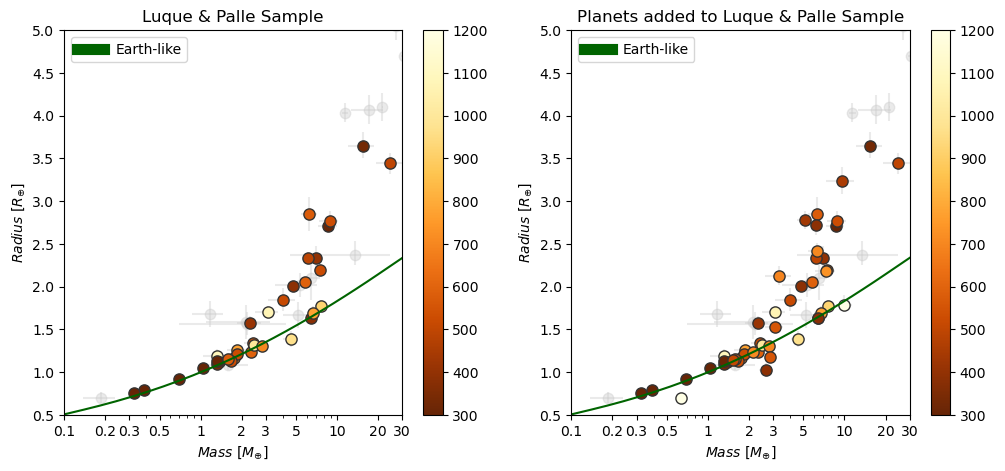

In [321]:
fig, ax = plt.subplots(figsize=(12,5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
        densities.append(density_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Luque & Palle Sample")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,radius2,xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(radius_low2),np.abs(radius_up2)],fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")
norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(temps)):
    if planet_name[i] in planets or planet_name[i] in planet2:
        plt.scatter(masses_add[i], radii_add[i], c=[temps[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Planets added to Luque & Palle Sample")
image_name = 'LIV34_add_RM.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


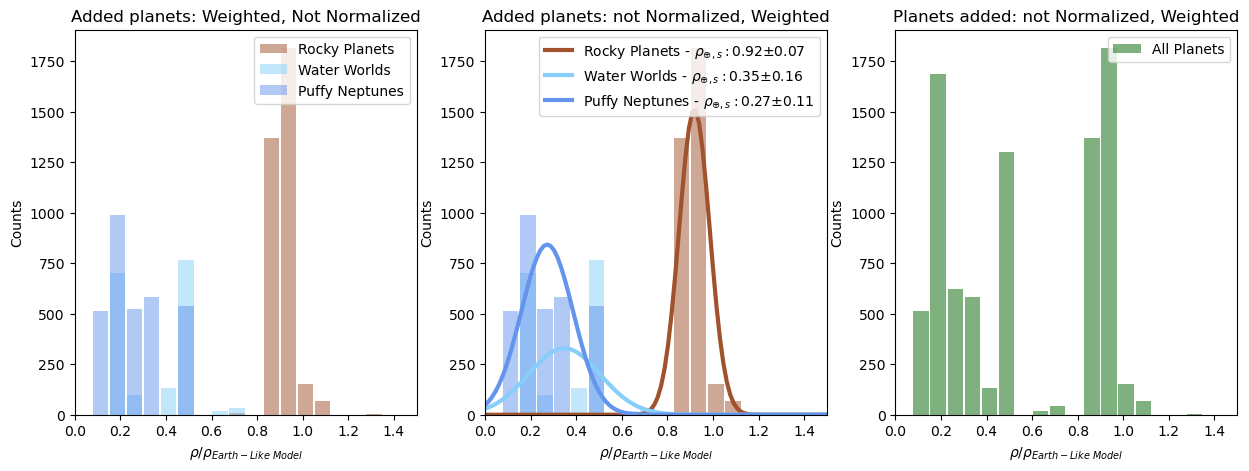

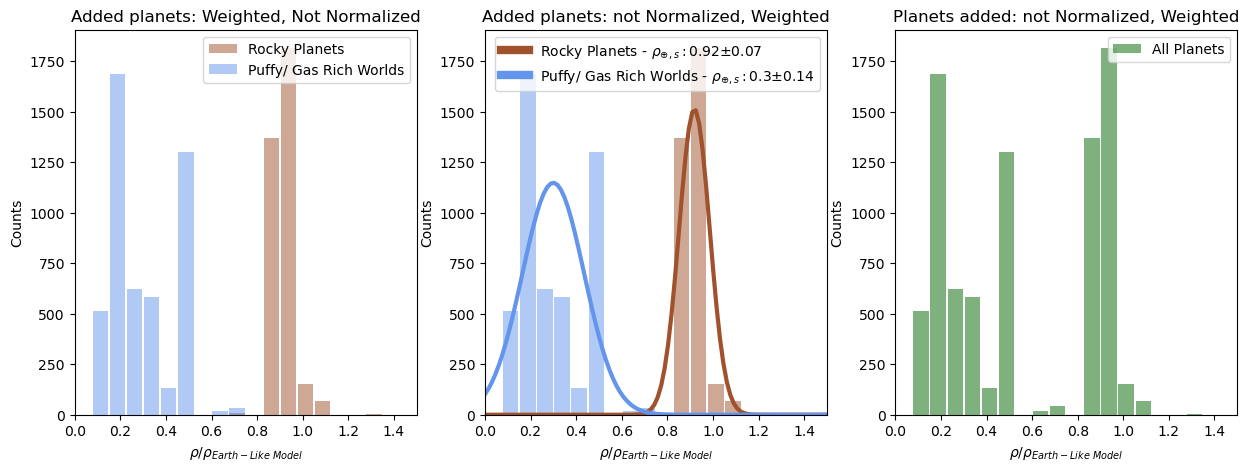

In [426]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_add[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False, weights=weight, label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight, label = "Puffy Neptunes")

##### Plotting ######
plt.title('Added planets: Weighted, Not Normalized')
plt.ylabel('Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 2)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*255
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_add[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*130
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*240
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Added planets: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 3)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "All Planets")
plt.title('Planets added: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_add_hist3pop.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Rocky Planets")

##### Water/Puffy Worlds #####
indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Puffy/ Gas Rich Worlds")

##### Plotting ######
plt.title('Added planets: Weighted, Not Normalized')
plt.ylabel('Counts')

leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 2)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*255
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water/Puffy Worlds #####
indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*391
plt.plot(pbins, best_fit_line,label ="Puffy/ Gas Rich Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Added planets: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 3)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "All Planets")
plt.title('Planets added: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])

image_name = 'LIV34_add_hist2pop.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

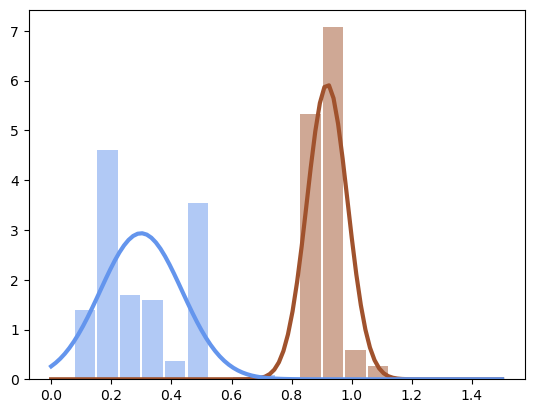

In [363]:
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water/Puffy Worlds #####
indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)

mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy/ Gas Rich Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)


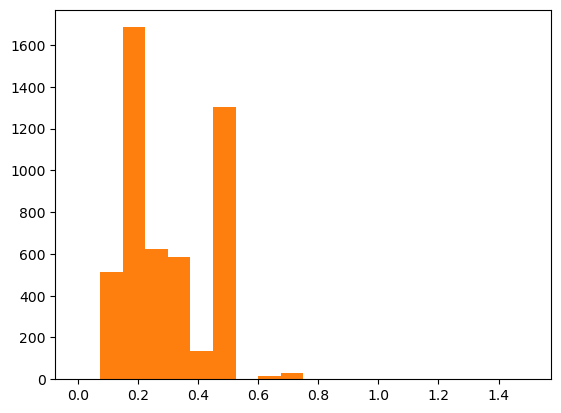

In [373]:
hist_counts = plt.hist(density_add[indexs], bins=bins, weights=weight,density=True)
hist_counts2 = plt.hist(density_add[indexs], bins=bins, weights=weight,density=False)


In [375]:
hist_counts[1][1]

0.075

Raw Counts: [   0.            0.            0.            0.            0.
    0.            0.            0.            0.           10.96680599
    0.         1369.5393675  1813.89364985  152.81917351   66.25730127
    0.            0.            5.92003962    0.            0.        ]
Normalized Counts: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04276313 0.         5.34027738
 7.07295858 0.59589143 0.25835867 0.         0.         0.02308415
 0.         0.        ]


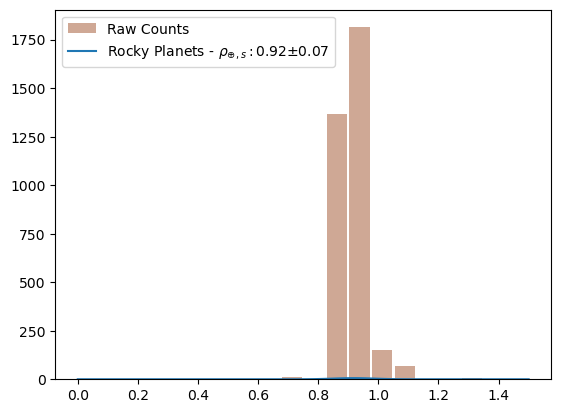

In [380]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code
indexs = index_rocky
weight = weight_rocky
bins = np.linspace(0, 1.5, 21)
density_values = density_add[indexs]

# Get the raw counts before normalization
raw_counts, bin_edges = np.histogram(density_values, bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_values, bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
# Plot the histogram with raw counts
plt.hist(density_values, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, weights=weight, label='Raw Counts')

mu = np.average(density_values, weights=weight)
sigma = np.sqrt(np.cov(density_values, aweights=weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line, label="Rocky Planets - " + "$ρ_{⊕,s}:$" + str(np.round(mu, 2)) + "±" + str(np.round(sigma, 2)))

# Get the normalized counts
normalized_counts, bin_edges = np.histogram(density_values, bins=bins, density=True, weights=weight)

# Print or use the raw and normalized counts for further analysis
print("Raw Counts:", raw_counts)
print("Normalized Counts:", normalized_counts)

# Show the plot
plt.legend()
plt.show()

In [383]:
normalized_counts[12]

7.072958579794107

In [386]:
sum(raw_counts)/sum(normalized_counts)

256.4547253298846